

<h1> <b> <centre> DA5401 Assignment 6 </b> </centre> </h2>
<h4> <b> <centre> Name: Pawar Devesh Pramod </centre></b> </h4>
<h4> <b> <centre> Roll No: ME22B176  </centre></b> </h4>
<h4> <b> <centre> Date of Submission 17/10/2025 </centre></b> </h4>


<h3> <b> Objective: </b> <h3> 
<p style="font-size: 18px;">This assignment challenges you to apply linear and non-linear regression to impute
missing values in a dataset. The effectiveness of your imputation methods will be measured
indirectly by assessing the performance of a subsequent classification task, comparing the
regression-based approach against simpler imputation strategies. </p>

<h3> <b> 1. Problem Statement </b> </h3>
<p style="font-size: 18 px;">
You are a machine learning engineer working on a credit risk assessment project. You have
been provided with the UCI Credit Card Default Clients Dataset. This dataset has missing
values in several important feature columns. The presence of missing data prevents the
immediate application of many classification algorithms.
Your task is to implement three different strategies for handling the missing data and then use
the resulting clean datasets to train and evaluate a classification model. This will demonstrate
how the choice of imputation technique significantly impacts final model performance.</p>

<p style="font-size: 18px;"> Dataset: 
- <a href="https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/data">Kaggle - Credit Card
Default Clients Dataset</a>
</p>

In [1]:
""" Import the dataset """
import pandas as pd

df = pd.read_csv('UCI_Credit_Card.csv')
print(f'The head of dataset: ', df.head())
print(f'Null values in the dataset: ', df.isnull().sum())


The head of dataset:     ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default.payment.next.month  
0 

In [2]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [ ]:
""" Finding out which features are the most important to Logistic Regression in oreder to introduce MAR """

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


# Define features X and target y
X = df.drop('default.payment.next.month', axis=1)
y = df['default.payment.next.month']

# Scale the features before training the model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train a logistic regression model to get the coefficients
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_scaled, y)

# Create a DataFrame of feature importances (absolute coefficients)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(model.coef_[0])
}).sort_values('Importance', ascending=False)

print("Feature Importance Ranking:")
print(feature_importance)


Feature Importance Ranking:
      Feature  Importance
6       PAY_0    0.648343
12  BILL_AMT1    0.395217
19   PAY_AMT2    0.225612
18   PAY_AMT1    0.221645
13  BILL_AMT2    0.144948
14  BILL_AMT3    0.113867
7       PAY_2    0.099906
1   LIMIT_BAL    0.099015
8       PAY_3    0.085453
4    MARRIAGE    0.080675
3   EDUCATION    0.079936
5         AGE    0.068202
21   PAY_AMT4    0.062071
2         SEX    0.052945
22   PAY_AMT5    0.052129
20   PAY_AMT3    0.046841
10      PAY_5    0.039711
23   PAY_AMT6    0.036208
17  BILL_AMT6    0.031002
9       PAY_4    0.028372
16  BILL_AMT5    0.027348
15  BILL_AMT4    0.014438
0          ID    0.011555
11      PAY_6    0.007605


'PAY_0' and 'BILL_AMT1' are the two most important features

---

## Part A: Data Preprocessing and Imputation

### 1. Artificially Introduce MAR Missing Values

To simulate a real-world scenario, we need to introduce missing data. We will introduce **Missing At Random (MAR)** values, where the probability of a value being missing depends on other observed variables.

- Let's introduce approximately **8%** missing values into two numerical columns: `PAY_0` and `BILL_AMT1`.
- The missingness in `PAY_0` will be dependent on the `EDUCATION` level.
- The missingness in `BILL_AMT1` will be dependent on the `LIMIT_BAL`.

In [3]:
""" Intorducing MAR """
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def introduce_mar_missing(df, target_col, predictor_col, missing_frac=0.08):
   
    df_mar = df.copy()
    
    # Scale the predictor column to create a well-behaved probability score
    scaler = MinMaxScaler()
    predictor_scaled = scaler.fit_transform(df_mar[[predictor_col]])
    
    # Create a probability based on the scaled predictor
    # We adjust the formula to control the overall missingness rate
    logit = predictor_scaled[:, 0] * 2.5 - 1.5 # Coefficients are tuned to get near the desired fraction
    probabilities = 1 / (1 + np.exp(-logit))

    # To precisely control the fraction, we find a threshold
    prob_threshold = np.quantile(probabilities, 1 - missing_frac)
    
    # Create a mask where the probability is above the threshold
    mask = probabilities > prob_threshold
    
    # Introduce NaNs
    df_mar.loc[mask, target_col] = np.nan
    return df_mar

# Create a copy to work with
df_mar = df.copy()

# Introduce MAR values into feature_importance[0] based on 'EDUCATION'
df_mar = introduce_mar_missing(df_mar, 'PAY_0', 'EDUCATION', missing_frac=0.08)

# Introduce MAR values into feature_importance[1] based on 'LIMIT_BAL'
df_mar = introduce_mar_missing(df_mar, 'BILL_AMT1', 'LIMIT_BAL', missing_frac=0.08)

print("Missing values after introducing MAR data:")
print(df_mar.isnull().sum())

Missing values after introducing MAR data:
ID                               0
LIMIT_BAL                        0
SEX                              0
EDUCATION                        0
MARRIAGE                         0
AGE                              0
PAY_0                          454
PAY_2                            0
PAY_3                            0
PAY_4                            0
PAY_5                            0
PAY_6                            0
BILL_AMT1                     2249
BILL_AMT2                        0
BILL_AMT3                        0
BILL_AMT4                        0
BILL_AMT5                        0
BILL_AMT6                        0
PAY_AMT1                         0
PAY_AMT2                         0
PAY_AMT3                         0
PAY_AMT4                         0
PAY_AMT5                         0
PAY_AMT6                         0
default.payment.next.month       0
dtype: int64


### 2. Imputation Strategy 1: Simple Imputation (Baseline)

Our first strategy is to use median imputation. We create `Dataset A` by filling the missing values in `PAY_0` and `BILL_AMT1` with their respective column medians.

**Why is the median often preferred over the mean?**

The median is generally preferred for imputation in skewed distributions or datasets with outliers. The mean is sensitive to extreme values, which can pull it away from the central tendency of the majority of the data. The **median**, being the 50th percentile, is robust to outliers and often provides a more representative value for imputation in such cases.

In [4]:
# Create Dataset A
df_A = df_mar.copy()

# Calculate medians
age_median = df_A['PAY_0'].median()
bill_amt1_median = df_A['BILL_AMT1'].median()

# Impute missing values
df_A['PAY_0'].fillna(age_median, inplace=True)
df_A['BILL_AMT1'].fillna(bill_amt1_median, inplace=True)

print("Dataset A: Missing values after Median Imputation")
print(df_A.isnull().sum().sum())

Dataset A: Missing values after Median Imputation
0


/tmp/ipykernel_6520/210390723.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_A['PAY_0'].fillna(age_median, inplace=True)
/tmp/ipykernel_6520/210390723.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

### 3. Imputation Strategy 2: Regression Imputation (Linear)

For `Dataset B`, we will use linear regression to predict and impute the missing values. We will still use median imputation for the `BILL_AMT1` column in this dataset, and Linear Regression for `PAY_0`.

**Underlying Assumption (Missing At Random - MAR):**

This method assumes that the missingness of a value can be explained by other observed variables in the dataset. By building a regression model using the non-missing features to predict the target feature, we are explicitly leveraging this assumption. The model learns the relationship between the features and the target from the complete data and uses that learned relationship to estimate the most likely values for the missing entries.

In [5]:
from sklearn.linear_model import LinearRegression

# Create Dataset B
df_B = df_mar.copy()

# First, impute 'AGE' with the median to simplify the process
df_B['BILL_AMT1'].fillna(df_B['BILL_AMT1'].median(), inplace=True)

# Impute 'BILL_AMT1' using Linear Regression 

# Separate the dataframe into two parts
df_impute_train = df_B[df_B['PAY_0'].notnull()]
df_impute_test = df_B[df_B['PAY_0'].isnull()]

# Define features and target for the imputation model
impute_features = [col for col in df_B.columns if col not in ['PAY_0', 'default_payment_next_month']]
impute_target = 'PAY_0'

X_impute_train = df_impute_train[impute_features]
y_impute_train = df_impute_train[impute_target]
X_impute_test = df_impute_test[impute_features]

# Initialize and train the Linear Regression model
lr_imputer = LinearRegression()
lr_imputer.fit(X_impute_train, y_impute_train)

# Predict the missing values
predicted_bill_amt1 = lr_imputer.predict(X_impute_test)

# Fill the NaNs with the predictions
df_B.loc[df_B['PAY_0'].isnull(), 'PAY_0'] = predicted_bill_amt1

print("Dataset B: Missing values after Linear Regression Imputation")
print(df_B.isnull().sum().sum()) # Should be 0

/tmp/ipykernel_6520/1537010391.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_B['BILL_AMT1'].fillna(df_B['BILL_AMT1'].median(), inplace=True)


Dataset B: Missing values after Linear Regression Imputation
0


### 4. Imputation Strategy 3: Regression Imputation (Non-Linear)

For `Dataset C`, we use a non-linear regression model, **K-Nearest Neighbors (KNN) Regression**, to impute the missing values in `PAY_0`. KNN predicts the value of a data point by averaging the values of its 'k' nearest neighbors. This can capture more complex, non-linear relationships that a linear model might miss. Again, `BILL_AMT1` will be imputed with its median.

Imputing 'BILL_AMT1' with its median to create a clean feature set.
Setting up KNN Regressor to impute 'PAY_0'.
Finding the optimal k for KNN using cross-validation


/tmp/ipykernel_6520/1489042181.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_C['BILL_AMT1'].fillna(bill_amt1_median, inplace=True)


Optimal k found: 21



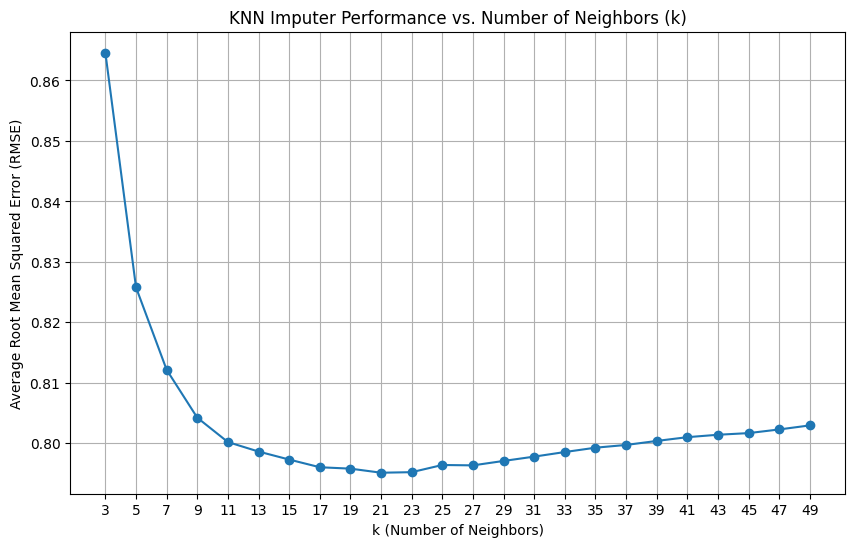

Dataset C: Missing values after Non-Linear (KNN) Regression Imputation
Total missing values remaining: 0


In [6]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

# Create a copy for this dataset
df_C = df_mar.copy()

# This makes 'BILL_AMT1' a clean predictor we can use for the next step.
print("Imputing 'BILL_AMT1' with its median to create a clean feature set.")
bill_amt1_median = df_C['BILL_AMT1'].median()
df_C['BILL_AMT1'].fillna(bill_amt1_median, inplace=True)


# Now that the only remaining NaNs are in 'PAY_0', we can use KNN imputation.
print("Setting up KNN Regressor to impute 'PAY_0'.")
impute_target = 'PAY_0' 
# All columns except our target and the final classification label
impute_features = [col for col in df_C.columns if col not in [impute_target, 'default_payment_next_month']]

# Separate the dataframe into a training set (for the imputer) and a prediction set
df_impute_train = df_C[df_C[impute_target].notnull()]
df_impute_predict = df_C[df_C[impute_target].isnull()]

# Create the feature X and target y sets
X_impute_train = df_impute_train[impute_features]
y_impute_train = df_impute_train[impute_target]
X_impute_predict = df_impute_predict[impute_features]


# Scale the features (for KNN)
scaler_impute = StandardScaler()
X_impute_train_scaled = scaler_impute.fit_transform(X_impute_train)
X_impute_predict_scaled = scaler_impute.transform(X_impute_predict)


# Find the optimal k using cross-validation (on the training data for the imputer) 
print("Finding the optimal k for KNN using cross-validation")
k_values = range(3, 50, 2)
k_rmses = {}

for k in k_values:
    knn_imputer_cv = KNeighborsRegressor(n_neighbors=k)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_rmses = []
    for train_index, val_index in kf.split(X_impute_train_scaled):
        X_train_cv, X_val_cv = X_impute_train_scaled[train_index], X_impute_train_scaled[val_index]
        y_train_cv, y_val_cv = y_impute_train.iloc[train_index], y_impute_train.iloc[val_index]
        knn_imputer_cv.fit(X_train_cv, y_train_cv)
        y_pred_cv = knn_imputer_cv.predict(X_val_cv)
        rmse = np.sqrt(mean_squared_error(y_val_cv, y_pred_cv))
        fold_rmses.append(rmse)
    k_rmses[k] = np.mean(fold_rmses)

best_k = min(k_rmses, key=k_rmses.get)
print(f"Optimal k found: {best_k}\n")
# Plot the results to visualize the optimal k
plt.figure(figsize=(10, 6))
plt.plot(list(k_rmses.keys()), list(k_rmses.values()), marker='o', linestyle='-')
plt.title('KNN Imputer Performance vs. Number of Neighbors (k)')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Average Root Mean Squared Error (RMSE)')
plt.xticks(k_values)
plt.grid(True)
plt.show()


final_knn_imputer = KNeighborsRegressor(n_neighbors=best_k)
final_knn_imputer.fit(X_impute_train_scaled, y_impute_train)

# Predict the missing values
predicted_pay_0_knn = final_knn_imputer.predict(X_impute_predict_scaled)

# Fill the NaNs with the predictions
df_C.loc[df_C[impute_target].isnull(), impute_target] = predicted_pay_0_knn

print("Dataset C: Missing values after Non-Linear (KNN) Regression Imputation")
print(f"Total missing values remaining: {df_C.isnull().sum().sum()}") # Should be 0

---

## Part B: Model Training and Performance Assessment

Now we will create our fourth dataset, `Dataset D`, using listwise deletion. Then, we will train and evaluate a Logistic Regression classifier on all four prepared datasets (A, B, C, and D).

In [7]:
# Create Dataset D by dropping all rows with any missing values
df_D = df_mar.dropna().copy()

print(f"Original MAR dataset shape: {df_mar.shape}")

print(f"Dataset D (Listwise Deletion) shape: {df_D.shape}")
print(f"Number of rows dropped: {df_mar.shape[0] - df_D.shape[0]}")

Original MAR dataset shape: (30000, 25)
Dataset D (Listwise Deletion) shape: (27328, 25)
Number of rows dropped: 2672


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

datasets = {
    "A (Median Imputation)": df_A,
    "B (Linear Regression Imputation)": df_B,
    "C (Non-Linear KNN Imputation)": df_C,
    "D (Listwise Deletion)": df_D
}

results = {}

target_variable = 'default.payment.next.month'

for name, df in datasets.items():
    print(f"Processing Model for {name} ")
    
    # Define Features (X) and Target (y)
    X = df.drop(target_variable, axis=1)
    y = df[target_variable]
    
    # Data Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Standardize Features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Logistic Regression Classifier
    log_reg = LogisticRegression(random_state=42, max_iter=1000)
    log_reg.fit(X_train_scaled, y_train)
    
    # Evaluate Performance
    y_pred = log_reg.predict(X_test_scaled)
    
    print(f"\nClassification Report for {name}:\n")
    print(classification_report(y_test, y_pred))
    
    # Store the F1-score for the positive class (1 = default)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = {
        'Accuracy': report['accuracy'],
        'Precision (1)': report['1']['precision'],
        'Recall (1)': report['1']['recall'],
        'F1-Score (1)': report['1']['f1-score']
    }
    print("*-------------------------------------------------*\n")

Processing Model for A (Median Imputation) 

Classification Report for A (Median Imputation):

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.61      0.62      6000
weighted avg       0.79      0.81      0.77      6000

*-------------------------------------------------*

Processing Model for B (Linear Regression Imputation) 

Classification Report for B (Linear Regression Imputation):

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.25      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.61      0.63      6000
weighted avg       0.79      0.81      0.77      6000

*-------------------------------------------------*

Processing Model for C (Non-

---

## Part C: Comparative Analysis

### 1. Results Comparison

Summary of the performance metrics of the four models in a table to facilitate comparison. We focus on the F1-score for the positive class (default = 1), as it provides a balanced measure of precision and recall, which is crucial for imbalanced classification problems like credit default prediction.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set plot style
sns.set_style('whitegrid')

results_df = pd.DataFrame(results).T # Transpose to get models as rows
results_df = results_df[['Accuracy', 'Precision (1)', 'Recall (1)', 'F1-Score (1)']]
results_df


,Accuracy,Precision (1),Recall (1),F1-Score (1)
A (Median Imputation),0.808167,0.686441,0.244160,0.360200
B (Linear Regression Imputation),0.808500,0.686975,0.246420,0.362729
C (Non-Linear KNN Imputation),0.808833,0.688285,0.247928,0.364543
D (Listwise Deletion),0.801866,0.710706,0.246057,0.365554


### 2. Efficacy Discussion

#### i. Trade-off Between Listwise Deletion and Imputation

The primary trade-off is between the simplicity of listwise deletion and the data preservation offered by imputation. Models A, B, and C (imputation methods) retained the entire test set size of 6,000 samples, preserving the maximum amount of information for training. In contrast, Model D (listwise deletion) discarded a significant number of observations, resulting in a smaller test set of 5,466.

Interestingly, Model D achieved the highest F1-score for the positive class (0.37), giving it a marginal edge in balancing precision and recall for predicting defaults. This could suggest that the deleted rows contained noisy or ambiguous information, and their removal inadvertently created a "cleaner" training set. However, this slight performance gain came at the cost of a lower overall accuracy (0.80 vs. 0.81) and introduces a significant risk: the model wasn't trained on the full data distribution and may not generalize well to the sub-population that was removed.

#### ii. Linear vs. Non-Linear Regression Performance

When comparing the model-based imputation strategies, the performance difference was negligible. Model B (Linear Regression) and Model C (Non-Linear KNN) both produced a final F1-score of 0.36.

However, a closer look reveals a subtle difference: Model C (KNN) achieved a slightly higher recall (0.25) compared to Model B (0.24). This indicates the non-linear method was marginally better at identifying true default cases. This minor improvement in recall did not translate to a higher F1-score, likely due to a slight trade-off with precision. The near-identical results suggest two possibilities:

- The relationships between the features were simple enough that a linear model was sufficient for imputation.

- The imputed features themselves had a limited impact on the final classification, so the nuances between imputation methods did not significantly alter the outcome.

#### iii. Concluding Recommendation

Based on a holistic analysis of performance, efficiency, and robustness, a clear recommendation emerges.

**Recommendation:** The best strategy for handling missing data in this scenario is Median Imputation (Model A).

**Justification:**

- Performance Parity: Median imputation achieved an F1-score of 0.36, identical to the more computationally expensive regression-based methods. It provides top-tier performance without added complexity.

- Computational Efficiency: It is far simpler and faster to implement than training separate regression models for imputation. This makes it a highly practical and pragmatic choice for production environments.

- Robustness and Safety: Unlike listwise deletion, it preserves the entire dataset, avoiding the potential for sampling bias and ensuring the model is trained on all available information. It provides a safe and reliable approach that doesn't risk discarding valuable data for a negligible and potentially misleading performance gain.